In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

# Nengo Interface

In [2]:
from nengo.neurons import *
from nengo.builder.neurons import *
from brian2 import *
import nengo
from nengo.dists import Uniform
from nengo.solvers import NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

BrianLogger.suppress_name('resolution_conflict')

class WilsonNeuron(NeuronType):
    """
    Wilson Neuron Model.
    
    Description
    -----------
    
    TODO
    
    Paramters
    ---------
    
    time constants in seconds
    voltages in mV
    
    References
    ----------
    [1] Wilson, Hugh R. "Simplified dynamics of human and mammalian neocortical neurons."
        Journal of theoretical biology 200.4 (1999): 375-388.

    
    """
    
    probeable = ('spikes', 'voltage', 'recovery', 'conductance')
    tauv = NumberParam('tauv')
    taur = NumberParam('taur')
    tauc = NumberParam('tauc')
    
    def __init__(self, thr=-0.20*mV, tauv=0.00097, taur=0.0056, tauc=0.0990):
        super(WilsonNeuron, self).__init__()
        self.thr = thr
        self.tauv = tauv
        self.taur = taur
        self.tauc = tauc
        mag = mamp
        res = ohm
        freq = 10*pi*Hz
        antiunit = siemens/farad
        self.namespace = {'tauv': self.tauv, 'taur': self.taur, 'tauc': self.tauc,
            'thr': self.thr, 'mag': mag, 'res': res, 'antiunit': antiunit, 'freq': freq}

        self.eqns = '''
        dv/dt = antiunit/tauv * (-((17.81 + 47.58*(v/mV) + 33.80*(v/mV)**2)*(v - 0.48*mV))
                            - 26*r*(v + 0.95*mV)
                            - 13*c*(v + 0.95*mV) + I*res) : volt
        dr/dt = Hz/taur * (-r + 1.29*(v/mV) + 0.79 + 3.30*((v/mV) + 0.38)**2) : 1
        dc/dt = Hz/tauc * (-c + 11*((v/mV) + 0.754)*((v/mV) + 0.69)) : 1
        I : amp  # = mag*sin(freq*t)
        '''
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("tauv", 0.00097)
        add("taur", 0.0056)
        add("tauh", 0.0990)
        return args
        
    def rates(self, x, gain, bias):
        return x  # todo
    
    def max_rates_intercepts(self, gain, bias):
        max_rates = self.rates(np.ones_like(gain), gain, bias)
        x_range = np.linspace(-1, 1, 101)
        rates = np.asarray([self.rates(np.ones_like(gain) * x, gain, bias)
                            for x in x_range])
        last_zeros = np.maximum(np.argmax(rates > 0, axis=0) - 1, 0)
        intercepts = x_range[last_zeros]
        return max_rates, intercepts
    
    def step_math(self, dt, briannet, brianens, brianmon, I, output, voltage, time):
        brianens.I = I*mamp
        briannet.run(dt*second)
        voltage[:] = brianmon.v[:,-1]/mV

In [3]:
class SimBrianNeurons(Operator):
    def __init__(self, neuron_type, neurons, I, output, states):
        super(SimBrianNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = neurons        
        self.reads = [states[0], I]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
        
        self.neurons.v = states[1].initial_value*mV
        self.neurons.r = states[2].initial_value
        self.neurons.c = states[3].initial_value
        self.brianens = neurons
        self.brianmon = StateMonitor(self.neurons, 'v', record=True)
        self.briannet = Network(self.brianens, self.brianmon)  # , update_I

    def make_step(self, signals, dt, rng):
        current = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(dt, self.briannet, self.brianens, self.brianmon, current, output, voltage, time)
        return step_nrn

    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]

In [4]:
@Builder.register(WilsonNeuron)
def build_wilsonneuron(model, neuron_type, neurons):
    
    model.sig[neurons]['voltage'] = Signal(
        -0.754*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        0.279*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        0.0*np.ones(neurons.size_in), name="%s.conductance" % neurons)
    thr = neuron_type.thr*mV
    
    brianens = NeuronGroup(neurons.size_in, neuron_type.eqns,
        threshold='v > thr', namespace=neuron_type.namespace, method='rk4')
    
    brianop = SimBrianNeurons(
        neuron_type=neuron_type,
        neurons=brianens,
        I=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[
            model.time,
            model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance']])

    model.params[neurons] = {'briannet': brianop.briannet, 'brianens': brianop.brianens}
    model.add_op(brianop)

In [5]:
class TransmitSpikes(Operator):
    def __init__(self, conn, spikes, states):
        super(TransmitSpikes, self).__init__()
        self.conn = conn
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            spiked = np.where(spikes > 0)[0]
            spiketimes = time * np.ones((spiked.shape[0])) * ms
            self.conn.briansgg.set_spikes(spiked, spiketimes)
        return step

    @property
    def spikes(self):
        return self.reads[0]
    

In [22]:
@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])

    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, WilsonNeuron):
        if not isinstance(conn.solver, NoSolver) and conn.solver.weights is False:
            raise BuildError("Connections to WilsonNeuorns must provide a NoSolver with weight=True"
                            " (got %s from %s to %s)" % (conn.solver, conn.pre_obj, conn.post_obj))
        #todo: check that conn_pre is emitting spikes
        briannet = model.params[conn.post_obj.neurons]['briannet']
        brianens = model.params[conn.post_obj.neurons]['brianens']
        briansgg = SpikeGeneratorGroup(conn.pre_obj.n_neurons, indices=[], times=[]*ms)  # filled in during TransmitSpikes
        transform = full_transform(conn, slice_pre=False)
        w = build_decoders(model, conn, rng, transform)[1]
        
        syn_eqn = '''
        dg/dt = -tau*g/second : 1 (clock-driven)
        I_post = g*amp : amp (summed)
        w : 1
        '''
        briansyn = Synapses(briansgg, brianens, namespace={'tau': 0.01},
            model=syn_eqn, on_pre='g += w', method='rk4')
#         briansyn = Synapses(briansgg, brianens, on_pre='v += 0.1*mV')  # w[i,j]  #todo: synaptic filter eqns
        briansyn.connect()
        briansyn.w = w.ravel()  # todo: ensure indexing is correct
        briannet.add(briansgg)
        briannet.add(briansyn)
        conn.briansgg = briansgg
        
        brianspiker = TransmitSpikes(conn, model.sig[conn.pre_obj]['out'], states=[model.time])
        model.add_op(brianspiker)

    else:
        return nengo.builder.connection.build_connection(model, conn)

WARNING    /home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)
 [py.warnings]


# Test

WARNING    /home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengo/base.py:105: SyntaxWarning: Creating new attribute 'briansgg' on '<Connection from <Ensemble (unlabeled) at 0x7f6dae79e0f0> to <Ensemble (unlabeled) at 0x7f6dae79e9b0>>'. Did you mean to change an existing attribute?
  SyntaxWarning)
 [py.warnings]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

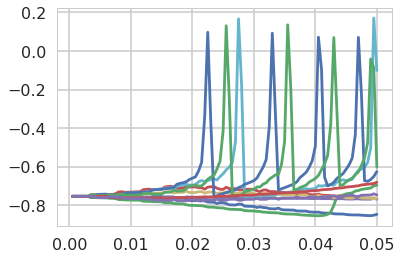

In [25]:
n_neurons = 10
Imag = 1
dt_nengo = 0.0005
w = 1e-4 * np.random.uniform(-1, 1, size=(n_neurons, n_neurons))

with nengo.Network(seed=1) as network:
    stim = nengo.Node(Imag * np.ones((n_neurons)))
    stim2 = nengo.Node(lambda t: sin(10*pi*t))
    lif = nengo.Ensemble(10, 1)
    ens = nengo.Ensemble(10, 1, neuron_type=WilsonNeuron(),
        encoders=Uniform(-1, 1), gain=Uniform(-1, 1), bias=Uniform(0, 0))
#     nengo.Connection(stim, ens.neurons, synapse=None)
    nengo.Connection(stim2, lif, synapse=None)
    nengo.Connection(lif, lif, synapse=0.01)
    nengo.Connection(lif, ens,
        solver=NoSolver(w, weights=True),
        synapse=0.01)
    p = nengo.Probe(ens.neurons, 'voltage')
    
with nengo.Simulator(network, dt=dt_nengo, seed=1) as sim:
    sim.run(0.05)
    
plt.plot(sim.trange(), sim.data[p])
plt.show()